<a href="https://colab.research.google.com/github/Anurag1902/Disaster-Tweets/blob/main/Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.2 MB/s eta 0:00:00


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.9 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
plt.style.use('fivethirtyeight')

import re
import string

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
# from transformers import AutoTokenizer
from transformers import BertTokenizer

import warnings
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_csv("/content/NLP_dataset.csv")
# test = pd.read_csv("/content/drive/MyDrive/NLP_dataset.csv")

In [10]:
data.head()

,tweet_id,tweet_text,class_label,canada wildfires_2016
0,7.360000e+17,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,other_relevant_information,NaN
1,7.310000e+17,Red Cross distributes $30M to Fort McMurray wi...,displaced_people_and_evacuations,NaN
2,7.340000e+17,Interesting insights on the shifting communica...,other_relevant_information,NaN
3,7.320000e+17,RT @globeandmail: Oil sands producers helping ...,rescue_volunteering_or_donation_effort,NaN
4,7.290000e+17,Ottawa to match Red Cross donations for Fort M...,rescue_volunteering_or_donation_effort,NaN


In [11]:
data['canada wildfires_2016'].unique()

array([nan, 'cyclone_idai_2019', 'ecuador_earthquake_2016',
       'hurricane_harvey_2017', 'hurricane_irma_2017',
       'hurricane_maria_2017', 'hurricane_matthew_2016',
       'italy_earthquake_aug_2016', 'kaikoura_earthquake_2016',
       'puebla_mexico_earthquake_2017', 'srilanka_floods_2017',
       'greece_wildfires_2018', 'maryland_floods_2018',
       'california_wildfires_2018', 'hurricane_dorian_2019',
       'hurricane_florence_2018', 'kerala_floods_2018',
       'midwestern_us_floods_2019', 'pakistan_earthquake_2019'],
      dtype=object)

In [12]:
data.drop(columns=['tweet_id','canada wildfires_2016'], inplace=True)

In [13]:
data.head()

,tweet_text,class_label
0,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,other_relevant_information
1,Red Cross distributes $30M to Fort McMurray wi...,displaced_people_and_evacuations
2,Interesting insights on the shifting communica...,other_relevant_information
3,RT @globeandmail: Oil sands producers helping ...,rescue_volunteering_or_donation_effort
4,Ottawa to match Red Cross donations for Fort M...,rescue_volunteering_or_donation_effort


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53531 entries, 0 to 53530
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_text   53531 non-null  object
 1   class_label  53531 non-null  object
dtypes: object(2)
memory usage: 836.5+ KB


### Pre-processing class_label

In [15]:
data['class_label'].unique()

array(['other_relevant_information', 'displaced_people_and_evacuations',
       'rescue_volunteering_or_donation_effort', 'caution_and_advice',
       'sympathy_and_support', 'infrastructure_and_utility_damage',
       'not_humanitarian', 'requests_or_urgent_needs',
       'injured_or_dead_people', 'missing_or_found_people'], dtype=object)

In [27]:
def assignLabels(label):
    if label == 'displaced_people_and_evacuations' or label =='caution_and_advice' or label =='injured_or_dead_people' or label =='infrastructure_and_utility_damage':
        return 1
    return 0

In [17]:
data['target'] = data['class_label'].apply(assignLabels)

In [18]:
data['target'].value_counts()

0    36132
1    17399
Name: target, dtype: int64

In [ ]:
values = data['target'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=['Count of 0','Count of 1',], values=values)])
fig.update_layout(template="plotly_dark",title={'text': "Count of Type",'y':0.9,
                                                'x':0.45,'xanchor': 'center','yanchor': 'top'},
                  font=dict(size=18, color='white', family="Courier New, monospace"))
fig.show()

In [ ]:
data['message_len'] = data['tweet_text'].apply(lambda x: len(str(x).split(' ')))
data.head()

,tweet_text,class_label,target,message_len
0,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,other_relevant_information,0,19
1,Red Cross distributes $30M to Fort McMurray wi...,displaced_people_and_evacuations,1,12
2,Interesting insights on the shifting communica...,other_relevant_information,0,16
3,RT @globeandmail: Oil sands producers helping ...,rescue_volunteering_or_donation_effort,0,15
4,Ottawa to match Red Cross donations for Fort M...,rescue_volunteering_or_donation_effort,0,12


In [ ]:
data['message_len'].unique()

array([19, 12, 16, 15, 10, 14,  6, 20,  9, 17, 13, 18, 27, 22, 21, 11, 23,
        8, 24, 25,  7,  5,  3,  4, 26, 28, 38, 33, 29, 35, 43, 32, 30, 40,
       39, 56, 44, 31, 34, 36, 37, 49, 41, 42, 50, 48, 46, 45, 52, 47, 51,
       54, 55, 53,  1, 59, 57, 58, 60, 61])

In [ ]:
fig = px.histogram(data, x='message_len')
fig.update_layout(template="plotly_dark",title={'text': "Phrase Length",'y':0.9,
                                                'x':0.45,'xanchor': 'center','yanchor': 'top'},
                  font=dict(size=18, color='white', family="Courier New, monospace"))
fig.show()

In [9]:
def text_clear(data):
    tx = data.apply(lambda x: re.sub("http\S+", '', str(x)))
    tx = tx.apply(lambda x: re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '',x))
    tx = tx.apply(lambda x: re.sub(' +', ' ', x)) # remover espaços em brancos
    tx = tx.apply(lambda x: re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', x)) # remover as hashtag
    tx = tx.apply(lambda x: re.sub('(@[A-Za-z]+[A-za-z0-9-_]+)', '', x)) # remover os @usuario
    tx = tx.apply(lambda x: re.sub('rt', '', x)) # remover os rt
    tx = tx.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    return tx

In [ ]:
data['tweet_text'] = text_clear(data['tweet_text'])
data.head()

,tweet_text,class_label,target,message_len
0,RT DonBradshawNTV How MarshallAmpsUK came to t...,other_relevant_information,0,19
1,Red Cross distributes 30M to Fo McMurray wildf...,displaced_people_and_evacuations,1,12
2,Interesting insights on the shifting communica...,other_relevant_information,0,16
3,RT globeandmail Oil sands producers helping wo...,rescue_volunteering_or_donation_effort,0,15
4,Ottawa to match Red Cross donations for Fo McM...,rescue_volunteering_or_donation_effort,0,12


In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
texts = data['tweet_text']
target = data['target']

train_input_ids, train_attention_masks = bert_encode(texts,61)

In [17]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(61,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(61,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = create_model(bert_model)

In [ ]:
stoped = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
redutor = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
history = model.fit([train_input_ids, train_attention_masks],
    target, validation_split=0.2, epochs=6, batch_size=16, callbacks=[stoped, redutor])

Epoch 1/6
2677/2677 [==============================] - 756s 258ms/step - loss: 0.2687 - accuracy: 0.8861 - val_loss: 0.1739 - val_accuracy: 0.9313 - lr: 1.0000e-05
Epoch 2/6
2677/2677 [==============================] - 675s 252ms/step - loss: 0.1995 - accuracy: 0.9190 - val_loss: 0.1667 - val_accuracy: 0.9337 - lr: 1.0000e-05
Epoch 3/6
2677/2677 [==============================] - 643s 240ms/step - loss: 0.1525 - accuracy: 0.9380 - val_loss: 0.1824 - val_accuracy: 0.9343 - lr: 1.0000e-05
Epoch 4/6
2677/2677 [==============================] - 671s 251ms/step - loss: 0.1034 - accuracy: 0.9607 - val_loss: 0.2308 - val_accuracy: 0.9347 - lr: 1.0000e-05
Epoch 5/6
2677/2677 [==============================] - 672s 251ms/step - loss: 0.0670 - accuracy: 0.9756 - val_loss: 0.2511 - val_accuracy: 0.9297 - lr: 1.0000e-05
Epoch 6/6
2677/2677 [==============================] - 671s 251ms/step - loss: 0.0435 - accuracy: 0.9845 - val_loss: 0.3658 - val_accuracy: 0.9283 - lr: 1.0000e-05


In [ ]:
history.history

{'loss': [0.2687201201915741,
  0.19949191808700562,
  0.15248465538024902,
  0.10343550145626068,
  0.0670030415058136,
  0.04353184998035431],
 'accuracy': [0.8861386179924011,
  0.9190407395362854,
  0.9380020499229431,
  0.9606762528419495,
  0.9756211638450623,
  0.9845413565635681],
 'val_loss': [0.17387263476848602,
  0.16674154996871948,
  0.18236246705055237,
  0.2307823896408081,
  0.25105106830596924,
  0.3657563626766205],
 'val_accuracy': [0.9312599301338196,
  0.933688223361969,
  0.9343420267105103,
  0.9347156286239624,
  0.9296721816062927,
  0.9282712340354919],
 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]}

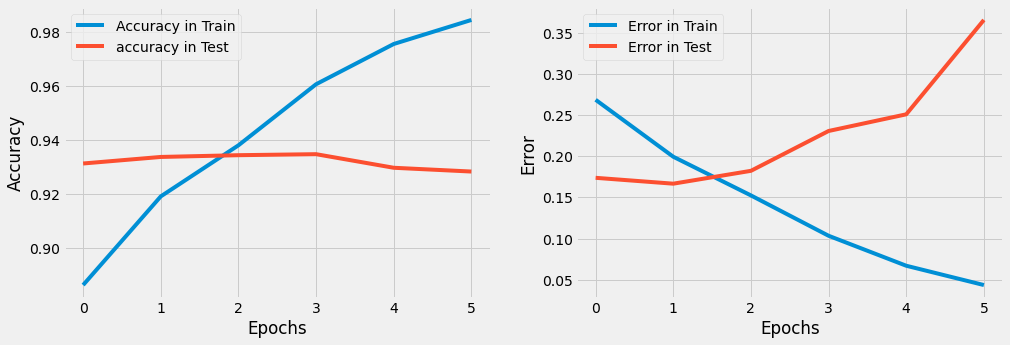

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Accuracy in Train','accuracy in Test'])
axes[0].grid(True)

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Error')
axes[1].legend(['Error in Train','Error in Test'])
axes[1].grid(True)

In [ ]:
model.save('model.h5')

In [ ]:
import pickle 

pickle.dump(model, open('model.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......input_layer
.........vars
......input_layer_1
.........vars
......tf_bert_model
.........bert
............embeddings
...............LayerNorm
..................vars
.....................0
.....................1
...............dropout
..................vars
...............vars
..................0
..................1
..................2
............encoder
...............layer
..................tf_bert_layer
.....................attention
........................dense_output
...........................LayerNorm
..............................vars
.................................0
.................................1
...........................dense
..............................vars
.................................0
.................................1
......................

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load and Predict Model 

In [5]:
from tensorflow.keras.models import load_model
import transformers
modelLoad = load_model('/content/drive/MyDrive/model.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [6]:
import pandas as pd
testData = pd.read_excel('/content/drive/MyDrive/NLP_Test_data.xlsx')

In [7]:
testData.head(10)

,tweet_id,tweet_text,class_label,Unnamed: 3,Unnamed: 4
0,7.286741e+17,RT @FoothillsFCU23: In response the to the #Fo...,rescue_volunteering_or_donation_effort,NaN,canada_wildfires_2016
1,7.297874e+17,Redcross is offering charitable donation recei...,rescue_volunteering_or_donation_effort,NaN,NaN
2,7.305104e+17,RT @globeandmail: Red Cross to transfer $50-mi...,rescue_volunteering_or_donation_effort,NaN,NaN
3,7.337059e+17,Live: Emergency operations briefing on north A...,other_relevant_information,NaN,NaN
4,7.306061e+17,"$9bn fire damage to Fort McMurray, â€˜the beas...",infrastructure_and_utility_damage,NaN,NaN
5,7.295106e+17,Labatt brewing water for Fort McMurray relief....,rescue_volunteering_or_donation_effort,NaN,NaN
6,7.296904e+17,RT @joshvisser: ICYMI: Free lap dances being o...,displaced_people_and_evacuations,NaN,NaN
7,7.288193e+17,RT @Iconix22: #ymmhelps #FortMacFire #ymmfire ...,other_relevant_information,NaN,NaN
8,7.290521e+17,RT @marcmack: Devastating wildfire in Fort McM...,displaced_people_and_evacuations,NaN,NaN
9,7.340663e+17,Survival Tip#11 #survival #prepping #evacuatio...,caution_and_advice,NaN,NaN


In [8]:
testData = testData.drop(['tweet_id','Unnamed: 3','Unnamed: 4'], axis = 1)

In [14]:
testData['tweet_text'] = text_clear(testData['tweet_text'])

In [15]:
testData.head(10)

,tweet_text,class_label
0,RT FoothillsFCU23 In response the to the FoMac...,rescue_volunteering_or_donation_effort
1,Redcross is offering charitable donation recei...,rescue_volunteering_or_donation_effort
2,RT globeandmail Red Cross to transfer 50millio...,rescue_volunteering_or_donation_effort
3,Live Emergency operations briefing on noh Albe...,other_relevant_information
4,9bn fire damage to Fo McMurray âthe beastâ wil...,infrastructure_and_utility_damage
5,Labatt brewing water for Fo McMurray relief la...,rescue_volunteering_or_donation_effort
6,RT joshvisser ICYMI Free lap dances being offe...,displaced_people_and_evacuations
7,RT Iconix22 ymmhelps FoMacFire ymmfire FoMcMur...,other_relevant_information
8,RT marcmack Devastating wildfire in Fo McMurra...,displaced_people_and_evacuations
9,Survival Tip11 survival prepping evacuation bu...,caution_and_advice


In [16]:
test_texts = testData['tweet_text']

In [20]:
test_input_ids, test_attention_masks = bert_encode(test_texts,61)
# print(test_input_ids,'  ',test_attention_masks)

In [21]:
predictions = modelLoad.predict([test_input_ids, test_attention_masks])

474/474 [==============================] - 2649s 6s/step


In [25]:
predictions

array([[3.9300385e-06],
       [8.4827670e-06],
       [6.4583354e-02],
       ...,
       [9.9985039e-01],
       [9.9985087e-01],
       [9.9934959e-01]], dtype=float32)

In [29]:
pd.set_option('display.max_colwidth', None)
testData['pred'] = [0 if x < .5 else 1 for x in predictions]
testData.head()

,tweet_text,class_label,target,pred
0,RT FoothillsFCU23 In response the to the FoMacFire we will be collecting cash donations at the gate before our final preseason game ht,rescue_volunteering_or_donation_effort,0,0
1,Redcross is offering charitable donation receipts for donations of 20 or more You can suppo Wildfire Relief at,rescue_volunteering_or_donation_effort,0,0
2,RT globeandmail Red Cross to transfer 50million to evacuees from Fo McMurray wildfire,rescue_volunteering_or_donation_effort,0,0
3,Live Emergency operations briefing on noh Albea wildfire,other_relevant_information,0,0
4,9bn fire damage to Fo McMurray âthe beastâ will affect forests carbon emissions air water pollution waste,infrastructure_and_utility_damage,1,1


In [31]:
testData['target'] = testData['class_label'].apply(assignLabels)
testData.head()

,tweet_text,class_label,target,pred
0,RT FoothillsFCU23 In response the to the FoMacFire we will be collecting cash donations at the gate before our final preseason game ht,rescue_volunteering_or_donation_effort,0,0
1,Redcross is offering charitable donation receipts for donations of 20 or more You can suppo Wildfire Relief at,rescue_volunteering_or_donation_effort,0,0
2,RT globeandmail Red Cross to transfer 50million to evacuees from Fo McMurray wildfire,rescue_volunteering_or_donation_effort,0,0
3,Live Emergency operations briefing on noh Albea wildfire,other_relevant_information,0,0
4,9bn fire damage to Fo McMurray âthe beastâ will affect forests carbon emissions air water pollution waste,infrastructure_and_utility_damage,1,1


In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [34]:
print("Accuracy score : ", accuracy_score(y_true = testData['target'], y_pred = testData['pred'] ))

Accuracy score :  0.9032321899736148


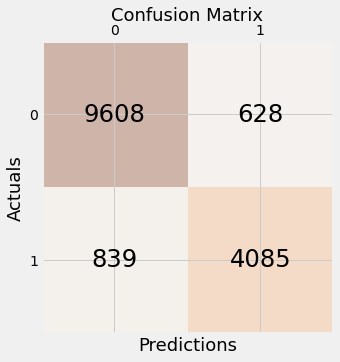

In [35]:
conf_matrix = confusion_matrix(y_true=testData['target'], y_pred= testData['pred'])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [40]:
def get_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [43]:
get_classification_report(testData['target'],testData['pred'])

,precision,recall,f1-score,support
0,0.919690,0.938648,0.929072,10236.000000
accuracy,0.903232,0.903232,0.903232,0.903232
weighted avg,0.902495,0.903232,0.902666,15160.000000
macro avg,0.893221,0.884129,0.888423,15160.000000
1,0.866752,0.829610,0.847774,4924.000000
